# Project 2

# Used Vehicle Price Prediction

#### Angie Paola Chacon Pinzon: 201012536
#### Jahir Stevens Rodriguez Riveros: 201819361
#### Juan Andres Cabal Jaramillo: 200620778
#### David Tavera Sánchez: 201016123

In [1]:
# Manipulación de los datos
import pandas as pd; pd.set_option('display.max_columns', None)
import numpy as np

# Estadísticas
from scipy import stats
import statistics

# Modelaje
from sklearn.preprocessing import scale 
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier

# Visualización
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# Progreso
from tqdm.notebook import trange, tqdm_notebook

## Introduction

- 1.2 Million listings scraped from TrueCar.com - Price, Mileage, Make, Model dataset from Kaggle: [data](https://www.kaggle.com/jpayne/852k-used-car-listings)
- Each observation represents the price of an used car

In [2]:
data = pd.read_csv('../P2ModelosAvanzados1/datasets/dataTrain_carListings.zip')

In [21]:
data.head()

,Price,Year,Mileage,State,Make,Model
0,21490,2014,31909,MD,Nissan,MuranoAWD
1,21250,2016,25741,KY,Chevrolet,CamaroCoupe
2,20925,2016,24633,SC,Hyundai,Santa
3,14500,2012,84026,OK,Jeep,Grand
4,32488,2013,22816,TN,Jeep,Wrangler


In [4]:
data.Price.describe()

count    500000.000000
mean      21144.186304
std       10753.259704
min        5001.000000
25%       13499.000000
50%       18450.000000
75%       26998.000000
max       79999.000000
Name: Price, dtype: float64

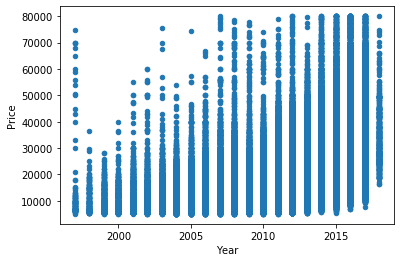

In [5]:
data.plot(kind='scatter', y='Price', x='Year')

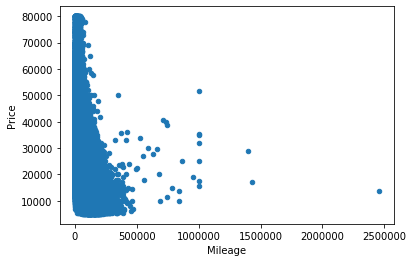

In [6]:
data.plot(kind='scatter', y='Price', x='Mileage')

In [7]:
data.columns

Index(['Price', 'Year', 'Mileage', 'State', 'Make', 'Model'], dtype='object')

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 6 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   Price    500000 non-null  int64 
 1   Year     500000 non-null  int64 
 2   Mileage  500000 non-null  int64 
 3   State    500000 non-null  object
 4   Make     500000 non-null  object
 5   Model    500000 non-null  object
dtypes: int64(3), object(3)
memory usage: 22.9+ MB


In [60]:
# Construimos las base de datos con las variables predictoras y la variable de respuesta.

# Conjunto de predictores
X_cat = data[['State', 'Make', 'Model']]
X_num = data[['Year', 'Mileage']]

X = pd.get_dummies(X_cat, drop_first = True)
X = pd.concat([X_num, X], axis=1, sort = False)

# Variable a predecir
y = data[['Price']]

print("Dimensión de los predictores:", X.shape)
print("Dimensión objetivo:", y.shape)

Dimensión de los predictores: (500000, 613)
Dimensión objetivo: (500000, 1)


# Exercise P2.1 (50%)

Develop a machine learning model that predicts the price of the of car using as an input ['Year', 'Mileage', 'State', 'Make', 'Model']

#### Evaluation:
- 25% - Performance of the models using a manually implemented K-Fold (K=10) cross-validation
- 25% - Notebook explaining the process for selecting the best model. You must specify how the calibration of each of the parameters is done and how these change the performance of the model. It is expected that a clear comparison will be made of all implemented models.. Present the most relevant conslusions about the whole process. 


### Bagging

#### Decision Tree Regressor

In [70]:
states = pd.get_dummies(data['State'])
makes = pd.get_dummies(data['Make'])
models = pd.get_dummies(data['Model'])
df = pd.concat([data[['Price', 'Year', 'Mileage']], states, makes, models], axis = 1)
df.shape

(500000, 617)

In [73]:
K = 10
N = data.shape[0]
acc = []

y = 'Price'

for i in tqdm_notebook(range(0,K)):
    X_test = df.loc[i*(N/K):(i+1)*(N/K)-1,]
    y_test = X_test[y]
    X_train = df.loc[set(data.index) - set(X_test.index),]
    y_train = X_train[y]
    X_test = X_test.drop(columns = y)
    X_train = X_train.drop(columns = y)
    clf = DecisionTreeRegressor(max_depth = None, random_state = 42)
    clf.fit(X_train, y_train)
    y_hat = clf.predict(X_test)
    acc.append(['RF',i, mean_squared_error(y_hat,y_test)])
    print ('RF iteración {} mse {}'.format(i, np.sqrt(mean_squared_error(y_hat,y_test))))

RF iteración 0 mse 4801.540622245261
RF iteración 1 mse 4712.8234246468255
RF iteración 2 mse 4701.985255471404
RF iteración 3 mse 4688.74915663998
RF iteración 4 mse 4687.069639958375
RF iteración 5 mse 4748.64683493769
RF iteración 6 mse 4780.043565118961
RF iteración 7 mse 4746.493734082468
RF iteración 8 mse 4787.364199674261
RF iteración 9 mse 4748.01220089719



In [61]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print("Dimensión Train:", X_train.shape)
print("Dimensión Test:", y_test.shape)

# set a seed for reproducibility
np.random.seed(42)

n_samples = X_train.shape[0]
n_B = 10

# create ten bootstrap samples (will be used to select rows from the DataFrame)
samples = [np.random.choice(a = n_samples, size = n_samples, replace = True) for _ in range(1, n_B + 1)]

Dimensión Train: (350000, 613)
Dimensión Test: (150000, 1)


In [54]:
RMSE = []
for t in tqdm_notebook(range(25, 35)):
    # grow each tree deep
    treereg = DecisionTreeRegressor(max_depth = t, random_state = 42)

    # DataFrame for storing predicted price from each tree
    y_pred = pd.DataFrame(index=y_test.index, columns=[list(range(n_B))])

    # grow one tree for each bootstrap sample and make predictions on testing data
    for i, sample in enumerate(samples):
        X = X_train.iloc[sample, 0:]
        y = y_train.iloc[sample]
        treereg.fit(X, y)
        y_pred[[i]] = treereg.predict(X_test)
        
    y_pred.mean(axis=1)
    RMSE.append(np.sqrt(mean_squared_error(y_test, y_pred.mean(axis=1))))

Text(0, 0.5, 'RMSE (lower is better)')

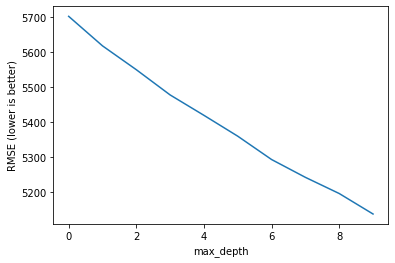

In [55]:
# Gráfica del RMSE
plt.plot(RMSE)
plt.xlabel('max_depth')
plt.ylabel('RMSE (lower is better)')

Como primer modelo de predicción implementamos un  árbol de decisión con 10 Fold Cross Validation. Para calibrar el modelo, escogemos, como primera opción, que la profundidad máxima del árbol sea igual a todos los nodos expandidos, en cuyo caso el RMSE es igual a 4,800. Luego de esto, iteramos para ver si reduciendo la profundidad del árbol el RMSE es menor, lo que permite concluir que utilizando una profundidad entre 25 y 35 el RMSE sigue siendo mayor a cuando la profundidad es máxima.

#### Rotation Forest

In [56]:
x_train, x_test_all, y_train, y_test_all = train_test_split(X, y, test_size = 0.3, random_state = 42)
x_dev, x_test, y_dev, y_test = train_test_split(x_test_all, y_test_all, test_size = 0.3, random_state = 9)

In [57]:
np.random.seed(42)
def get_random_subset(iterable, k):
    
    subsets = []
    iteration = 0
    np.random.shuffle(iterable)
    subset = 0
    limit = len(iterable)/k
    
    while iteration < limit:
        if k <= len(iterable):
            subset = k
        else:
            subset = len(iterable)
        subsets.append(iterable[-subset:])
        del iterable[-subset:]
        iteration+=1
        return subsets

def build_rotationtree_model(x_train, y_train, d, k):
    
    models = []
    r_matrices = []
    feature_subsets = []
    
    for i in tqdm_notebook(range(d)):
        x,_,_,_ = train_test_split(x_train, y_train, test_size = 0.3, random_state = 7)
        # Features ids
        feature_index = list(range(x.shape[1]))
        # Get subsets of features
        random_k_subset = get_random_subset(feature_index,k)
        feature_subsets.append(random_k_subset)
        # Rotation matrix
        R_matrix = np.zeros((x.shape[1],x.shape[1]),dtype=float)
        for each_subset in random_k_subset:
            pca = PCA()
            x_subset = x.iloc[:,each_subset]
            pca.fit(x_subset)
            for ii in range(0,len(pca.components_)):
                for jj in range(0,len(pca.components_)):
                    R_matrix[each_subset[ii],each_subset[jj]] = pca.components_[ii,jj]
                
        x_transformed = x_train.dot(R_matrix)
        
        model = DecisionTreeRegressor()
        model.fit(x_transformed,y_train)
        models.append(model)
        r_matrices.append(R_matrix)
    return models, r_matrices, feature_subsets
    
def model_worth(models, r_matrices, x, y):
    
    predicted_ys = []
    mses = []
    for i,model in tqdm_notebook(enumerate(models)):
        x_mod =  x.dot(r_matrices[i])
        predicted_y = model.predict(x_mod)
        predicted_ys.append(predicted_y)
        
        mse = np.sqrt(mean_squared_error(y, predicted_y))
        mses.append(mse)
        
        mse_avg = statistics.mean(mses) 
    
    print(mse_avg)

In [58]:
models, r_matrices, features = build_rotationtree_model(x_train, y_train, 10, 200)

In [59]:
# list of values to try for max_features
learning_range = np.arange(0.2, 1, 0.2)
n_estimator_range = range(200, 600, 100)
max_depth_range = range(9, 15, 3)

# list to store the average Accuracy for each value of max_features
#accuracy_scores = []

for lr in learning_range:
    for n in n_estimator_range:
        for m in max_depth_range:
            now()
            clf = GradientBoostingRegressor(random_state=0, learning_rate = lr, n_estimators=n,max_depth=m)
            clf.fit(X_train,y_train)
            y_pred=clf.predict(X_test)
            mse=metrics.mean_squared_error(y_pred,y_test)
            print('learning_range {}, n_estimators {}, max_depth {}, mse {}'.format(lr,n, m, mse))
            accuracy_scores.append([lr,n, m, mse])

Current Time = 08:28:57
learning_range 0.1,n_estimators 50, max_depth 1, mse 75230206.1236172
Current Time = 08:30:03
learning_range 0.1,n_estimators 50, max_depth 2, mse 63862130.65263713
Current Time = 08:32:46
learning_range 0.1,n_estimators 50, max_depth 3, mse 55679530.58052121
Current Time = 08:37:33
learning_range 0.1,n_estimators 50, max_depth 4, mse 49330189.46672898
Current Time = 08:44:41
learning_range 0.1,n_estimators 50, max_depth 5, mse 43909866.89225197
Current Time = 08:54:34
learning_range 0.1,n_estimators 50, max_depth 6, mse 40128544.43770137
Current Time = 09:07:20
learning_range 0.1,n_estimators 50, max_depth 7, mse 36699278.88626893
Current Time = 09:22:52
learning_range 0.1,n_estimators 50, max_depth 8, mse 34265379.6500807
Current Time = 09:42:26
learning_range 0.1,n_estimators 50, max_depth 9, mse 32154287.39635317
Current Time = 10:06:37
learning_range 0.1,n_estimators 100, max_depth 1, mse 66317968.88067939
Current Time = 10:08:27
learning_range 0.1,n_estima

Adicional al modelo de Random Forest, intentamos aplicar un Rotatio Forest en donde se se combina un Random Forest junto con componentes principales. Lo anterior con el fin de ver si al reducir la dimensionalidad de la base la predicción mejora. Sin embargo, al correr el modelo con 10 árboles y utilizando 200 variables el RSME sigue siendo superior al árbol de decisión.

### Boosting

In [ ]:
y = data['Price']
X = data.drop(['Price'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

- Learning rate:  0<𝜂≤1. Fracción de los componentes de un árbol que serán usadas para la estimación del siguiente árbol. Es usado para mejorar la generalización del árbol. Cuando más pequeño es el parámetro es mejor la generalización que hace. Cuándo el valor es 1, significa que se usan todos los componentes del árbol actual para crear el siguiente árbol
- gamma: Ganancia mínima que debe superar una partición para ser incluida en el árbol. Es un número entre [0,inf] y a medida que es más grande el árbol final es más simple.
- colsample_bytree: Fracción de las columnas que serán tomadas para la construcción de cada árbol. tiene un valor entre 0 y 1 siendo 1:"tomar todas las columnas"

In [ ]:
# list of values to try for max_features
learning_range = np.arange(0, 1, 0.1)
gamma_range = range(1, 10)
colsample_range =np.arange(0, 1, 0.1)

# list to store the average Accuracy for each value of max_features
accuracy_scores = []

for lr in learning_range:
    for g in gamma_range:
        for cs in colsample_range:
            clf = XGBClassifier(eta=lr, gamma=g,colsample_bytree=cs)
            clf.fit(X_train,y_train)
            y_pred=clf.predict(X_test)
            acc=metrics.accuracy_score(y_pred,y_test)
            accuracy_scores.append([lr,g,cs,acc])

# Exercise P2.2 (50%)

Create an API of the model.

Example:
![](https://raw.githubusercontent.com/albahnsen/PracticalMachineLearningClass/master/notebooks/images/img015.PNG)

#### Evaluation:
- 40% - API hosted on a cloud service
- 10% - Show screenshots of the model doing the predictions on the local machine


Create Model

In [44]:
states = pd.get_dummies(data['State'])
makes = pd.get_dummies(data['Make'])
models = pd.get_dummies(data['Model'])
df = pd.concat([data[['Price', 'Year', 'Mileage']], states, makes, models], axis = 1)
df.shape

(500000, 617)

In [46]:
K = 10
N = data.shape[0]

y = 'Price'

for i in range(0,K):
    X_test = df.loc[i*(N/K):(i+1)*(N/K)-1,]
    y_test = X_test[y]
    X_train = df.loc[set(data.index) - set(X_test.index),]
    y_train = X_train[y]
    X_test = X_test.drop(columns = y)
    X_train = X_train.drop(columns = y)
    clf = DecisionTreeRegressor(max_depth = 33, random_state = 42)
    clf.fit(X_train, y_train)

In [47]:
from sklearn.externals import joblib
joblib.dump(clf, 'model_deployment/mimodelo.pkl', compress=3)

['model_deployment/mimodelo.pkl']